In [1]:
import pandas as pd
import numpy as np
import sys
import os
import os.path
import random
from pathlib import Path
from time import time
from itertools import chain

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


# ML
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
#from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer,StandardScaler, MinMaxScaler,OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, LSTM, Embedding
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow

#####################################W
# Settings
#####################################
plt.style.use('seaborn')
# Set random seed to make results reproducable
np.random.seed(42)
tensorflow.set_random_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
# Improve printed df readability
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

print(os.listdir("../input"))

Using TensorFlow backend.


['marketdata_sample.csv', 'news_sample.csv']


In [2]:
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [3]:
(market, news) = env.get_training_data()
market.time = market.time.astype('datetime64[D, UTC]')
news.time = news.time.astype('datetime64[D, UTC]')

In [4]:
market[:10]

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,"2,606,900.0000",32.1900,32.1700,0.0059,0.0053,nan,nan,-0.0019,0.0006,nan,nan,0.0347,1.0000
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,"2,051,600.0000",11.1200,11.0800,0.0045,-0.0072,nan,nan,-0.0787,-0.0881,nan,nan,0.0278,0.0000
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,"1,164,800.0000",37.5100,37.9900,-0.0116,0.0256,nan,nan,0.0143,0.0454,nan,nan,0.0244,1.0000
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,"23,747,329.0000",84.7400,86.2300,-0.0115,0.0163,nan,nan,-0.0486,-0.0372,nan,nan,-0.0074,1.0000
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,"1,208,600.0000",18.0200,18.0100,0.0118,0.0250,nan,nan,0.0129,0.0204,nan,nan,-0.0180,1.0000
5,2007-02-01 22:00:00+00:00,ABC.N,AmerisourceBergen Corp,"1,657,300.0000",52.3700,52.4000,-0.0002,0.0085,nan,nan,0.0890,0.0777,nan,nan,0.0587,1.0000
6,2007-02-01 22:00:00+00:00,ABD.N,ACCO Brands Corp,"1,186,200.0000",23.6300,24.1300,-0.0207,-0.0074,nan,nan,0.0051,0.0268,nan,nan,-0.0443,0.0000
7,2007-02-01 22:00:00+00:00,ABM.N,ABM Industries Inc,"301,200.0000",26.1900,25.9000,0.0135,0.0149,nan,nan,0.0690,0.0473,nan,nan,0.0166,0.0000
8,2007-02-01 22:00:00+00:00,ABT.N,Abbott Laboratories,"5,692,300.0000",52.8700,52.5000,-0.0025,-0.0047,nan,nan,0.0015,-0.0049,nan,nan,0.0099,1.0000
9,2007-02-01 22:00:00+00:00,ABV.N,Companhia de Bebidas das Americas Ambev,"401,800.0000",52.4600,52.1000,0.0141,0.0248,nan,nan,0.0423,0.0274,nan,nan,0.0129,1.0000


In [5]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072956 entries, 0 to 4072955
Data columns (total 16 columns):
time                        datetime64[ns, UTC]
assetCode                   object
assetName                   category
volume                      float64
close                       float64
open                        float64
returnsClosePrevRaw1        float64
returnsOpenPrevRaw1         float64
returnsClosePrevMktres1     float64
returnsOpenPrevMktres1      float64
returnsClosePrevRaw10       float64
returnsOpenPrevRaw10        float64
returnsClosePrevMktres10    float64
returnsOpenPrevMktres10     float64
returnsOpenNextMktres10     float64
universe                    float64
dtypes: category(1), datetime64[ns, UTC](1), float64(13), object(1)
memory usage: 474.1+ MB


In [6]:
market.describe()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
count,"4,072,956.0000","4,072,956.0000","4,072,956.0000","4,072,956.0000","4,072,956.0000","4,056,976.0000","4,056,968.0000","4,072,956.0000","4,072,956.0000","3,979,946.0000","3,979,902.0000","4,072,956.0000","4,072,956.0000"
mean,"2,665,311.9054",39.7124,39.7123,0.0005,0.0096,0.0002,0.0093,0.0052,0.0142,0.0016,0.0148,0.0141,0.5949
std,"7,687,605.7884",42.2882,42.6112,0.0370,7.0844,0.0327,6.9689,0.0887,7.1236,0.0752,7.2857,7.2425,0.4909
min,0.0000,0.0700,0.0100,-0.9776,-0.9999,-1.2356,-615.8463,-0.9774,-0.9999,-3.3433,"-1,375.0451","-1,375.0451",0.0000
25%,"465,796.7500",17.2500,17.2500,-0.0109,-0.0111,-0.0086,-0.0100,-0.0334,-0.0334,-0.0293,-0.0296,-0.0297,0.0000
50%,"982,100.0000",30.3000,30.2900,0.0003,0.0004,-0.0001,-0.0000,0.0052,0.0052,0.0008,0.0011,0.0010,1.0000
75%,"2,403,165.0000",49.8600,49.8500,0.0117,0.0118,0.0084,0.0100,0.0430,0.0430,0.0306,0.0317,0.0315,1.0000
max,"1,226,791,285.0000","1,578.1300","9,998.9900",45.5925,"9,209.0000",45.1224,"8,989.2066",46.6718,"9,382.0000",46.2497,"9,761.3383","9,761.3383",1.0000


In [7]:
nassets = len(market.assetName.unique().categories)
nrows = market.close.count()
print("Total count: %d records of %d assets" % (nrows, nassets))

Total count: 4072956 records of 3511 assets


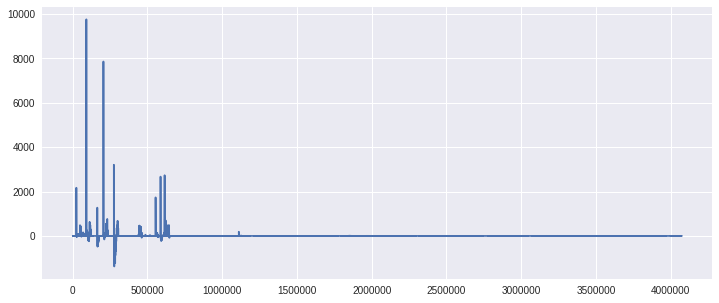

In [8]:
market.returnsOpenNextMktres10.plot(figsize = (12, 5))

In [9]:
market.returnsOpenNextMktres10.describe(percentiles = [0.01, 0.99])

count   4,072,956.0000
mean            0.0141
std             7.2425
min        -1,375.0451
1%             -0.1888
50%             0.0010
99%             0.2079
max         9,761.3383
Name: returnsOpenNextMktres10, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


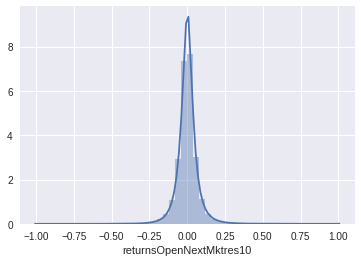

In [10]:
sns.distplot(market.returnsOpenNextMktres10.clip(-1, 1))

In [11]:
def plot_random_asset(market):
    ass = market.assetCode.sample(1, random_state = 24).iloc[0]
    ass_market = market[market['assetCode'] == ass]
    ass_market.index = ass_market.time
    
    # Plot
    f, axs = plt.subplots(3, 1, sharex = True, figsize = (12, 8))
    
    # Price
    ass_market.close.plot(ax = axs[0])
    axs[0].set_ylabel("Price")
    # Volatility (close - open)
    volat_df = (ass_market.close - ass_market.open)
    volat_df.plot(color = 'green', ax = axs[1])
    axs[1].set_ylabel("Volatility")
    # Volume
    ass_market.volume.plot(ax = axs[2], color = 'darkred')
    axs[2].set_ylabel("Volume")
    
    f.suptitle("Asset: %s" % ass, fontsize = 22)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.93)
    plt.show()

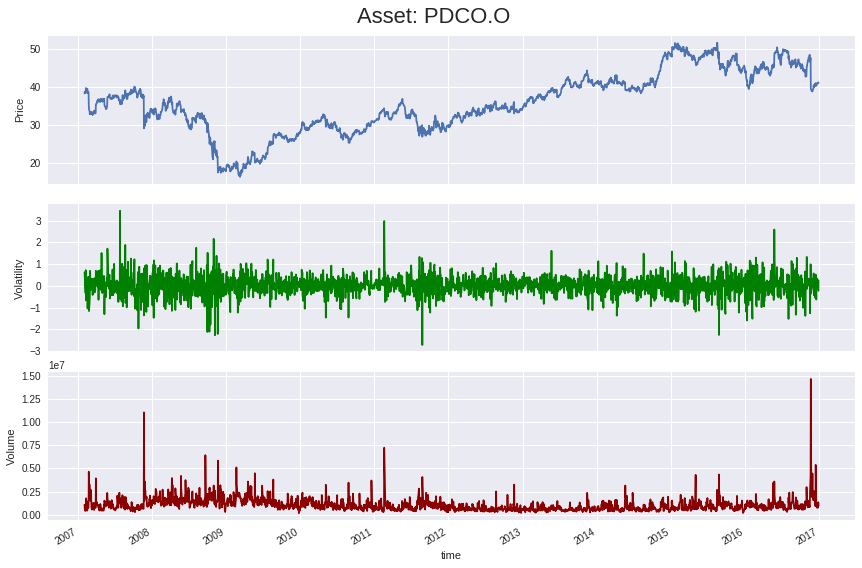

In [12]:
plot_random_asset(market)

In [13]:
news[:5]

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'ENR', 'ASIA', 'CN', 'NGS', 'EMRG', 'RTRS', '...","{'Z', 'O', 'OIL'}",1438,1,,False,11,275,"{'0857.HK', '0857.F', '0857.DE', 'PTR.N'}",PetroChina Co Ltd,6,0.2357,-1,0.5007,0.4193,0.0799,73,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'FEA', 'CA', 'LATAM', 'MX', 'INS', 'ASIA', 'I...","{'PGE', 'PCO', 'G', 'ESN', 'MD', 'PCU', 'DNP',...",4413,1,FEATURE,False,55,907,{'STA.N'},Travelers Companies Inc,8,0.4472,-1,0.6001,0.3459,0.0541,62,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'RET', 'ENR', 'ID', 'BG', 'US', 'PRESS', 'IQ'...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",2108,2,PRESS DIGEST,False,15,388,"{'WMT.DE', 'WMT.N'}",Wal-Mart Stores Inc,14,0.3780,-1,0.4500,0.2957,0.2543,67,0,0,0,0,0,0,0,5,11,17
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,"{'GOOG.O', 'GOOG.OQ', 'GOOGa.DE'}",Google Inc,13,0.1491,-1,0.7529,0.1627,0.0844,83,0,0,0,0,0,0,0,5,13,15
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'FUND', 'FIN', 'CA', 'SFWR', 'INS', 'PUB', 'B...","{'T', 'DNP', 'PSC', 'U', 'D', 'M', 'RNP', 'PTD...",1776,6,PRESS DIGEST,False,14,325,{'XMSR.O'},XM Satellite Radio Holdings Inc,11,0.1491,-1,0.6993,0.2094,0.0914,102,0,0,0,0,0,0,0,0,0,0


In [14]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9328750 entries, 0 to 9328749
Data columns (total 35 columns):
time                    datetime64[ns, UTC]
sourceTimestamp         datetime64[ns, UTC]
firstCreated            datetime64[ns, UTC]
sourceId                object
headline                object
urgency                 int8
takeSequence            int16
provider                category
subjects                category
audiences               category
bodySize                int32
companyCount            int8
headlineTag             object
marketCommentary        bool
sentenceCount           int16
wordCount               int32
assetCodes              category
assetName               category
firstMentionSentence    int16
relevance               float32
sentimentClass          int8
sentimentNegative       float32
sentimentNeutral        float32
sentimentPositive       float32
sentimentWordCount      int32
noveltyCount12H         int16
noveltyCount24H         int16
noveltyCount3

In [15]:
nnews = news.size
nassets = len(news.assetName.cat.categories)
print("Total %d news about %d assets" % (nnews, nassets))

Total 326506250 news about 9464 assets


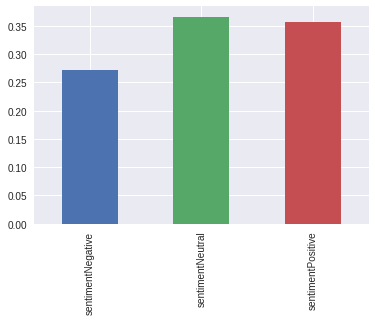

In [16]:
news[['sentimentNegative', 'sentimentNeutral', 'sentimentPositive']].mean().plot(kind = 'bar')

In [17]:
toy = True

In [18]:
def train_test_val_split(market):
    market_idx = market[market.time > '2009'][['time', 'assetCode']]
    if toy: market_idx = market_idx.sample(100000)
    else: market_idx = market_idx.sample(1000000)
    # Split
    market_idx = market_idx.sort_values(by = ['time'])
    market_train_idx, market_test_idx = train_test_split(market_idx, shuffle = False, random_state = 24)
    market_train_idx, market_val_idx = train_test_split(market_train_idx, test_size = 0.1, shuffle = False, random_state = 24)
    return (market_train_idx, market_val_idx, market_test_idx)

In [19]:
market_train_idx, market_val_idx, market_test_idx = train_test_val_split(market)

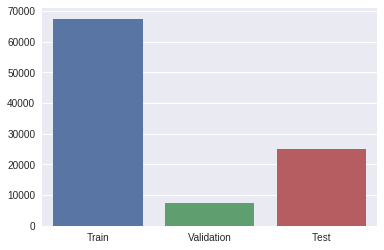

In [20]:
sns.barplot(['Train', 'Validation', 'Test'], [market_train_idx.index.size, market_val_idx.index.size, market_test_idx.index.size])

In [21]:
class MarketPrepro:
    # Features
    assetcode_encoded = []
    assetcode_train_count = 0
    time_cols = ['year', 'week', 'day', 'dayofweek']
    numeric_cols = ['volume', 'close', 'open', 
                    'returnsClosePrevRaw1', 
                    'returnsOpenPrevRaw1', 
                    'returnsClosePrevMktres1', 
                    'returnsOpenPrevMktres1', 
                    'returnsClosePrevRaw10', 
                    'returnsOpenPrevRaw10', 
                    'returnsClosePrevMktres10', 
                    'returnsOpenPrevMktres10']
    feature_cols = ['assetCode_encoded'] + time_cols + numeric_cols
    
    # Labels
    label_cols = ['returnsOpenNextMktres10']
    
    def __init__(self):
        self.cats = {}
        
    def safe_fix(self, df):
        # Fill N/A, fix outliers, no rows removed
        df[self.numeric_cols] = df[['assetCode'] + self.numeric_cols].groupby('assetCode')\
        .transform(lambda g: g.fillna(method = 'bfill'))
        df[self.numeric_cols] = df[self.numeric_cols].fillna(0)
        df[self.numeric_cols] = df[self.numeric_cols].clip(df[self.numeric_cols].quantile(0.01), df[self.numeric_cols].quantile(0.99), axis = 1)
        return (df)
    
    def fix_train(self, train_df):
        # Remove bad data. For train dataset only.
        max_ratio = 2
        train_df = train_df[(train_df['close'] / train_df['open']).abs() <= max_ratio].loc[:]
        train_df = self.safe_fix(train_df)
        return (train_df)
        
    def fit(self, market_train_df):
        # Fit preprocessing scalers
        df = market_train_df.copy()
        market_train_df = self.fix_train(market_train_df)
        market_train_df = self.prepare_time_cols(market_train_df)
        self.numeric_scaler = StandardScaler()
        self.numeric_scaler.fit(market_train_df[self.numeric_cols + self.time_cols].astype(float))
        market_train_df = self.encode_asset(market_train_df, True)
        
    def get_X(self, df):
        # Preprocess and return X without y
        df = df.copy()
        # Fix bad data without removing rows
        df = self.safe_fix(df)

        # Add day, week, year
        df = self.prepare_time_cols(df)
        # Encode assetCode
        df = self.encode_asset(df, is_train=False)
        # Scale numeric features and labels
        df[self.numeric_cols+self.time_cols] = self.numeric_scaler.transform(df[self.numeric_cols+self.time_cols].astype(float))

        # Return X
        return df[self.feature_cols]
    
    def get_y(self, df):
        y=(df[self.label_cols] >=0).astype(float)
        return y
    
    def encode_asset(self, df, is_train):
        def encode(assetcode):
            """
            Encode categorical features to numbers
            """
            try:
                # Transform to index of name in stored names list
                index_value = self.assetcode_encoded.index(assetcode) +1
            except ValueError:
                # If new value, add it to the list and return new index
                self.assetcode_encoded.append(assetcode)
                index_value = len(self.assetcode_encoded)

            #index_value = 1.0/(index_value)
            index_value = index_value / (self.assetcode_train_count + 1)
            return(index_value)       
        
        if is_train:
            self.assetcode_train_count = len(df['assetCode'].unique())+1
        df['assetCode_encoded'] = df['assetCode'].apply(lambda assetcode: encode(assetcode))
        return(df)
        
    def prepare_time_cols(self, df):
        """ 
        Extract time parts, they are important for time series 
        """
        df = df.copy()
        df['year'] = df['time'].dt.year
        # Maybe remove month because week of year can handle the same info
        df['day'] = df['time'].dt.day
        # Week of year
        df['week'] = df['time'].dt.week
        df['dayofweek'] = df['time'].dt.dayofweek
        return(df)

In [22]:
# Create instance for global usage    
market_prepro = MarketPrepro()
print('market_prepro created')

market_prepro created


In [23]:
class NewsPrepro:
    """
    Aggregate news by day and asset. Normalize numeric values.
    """
    news_cols_agg = {
        'urgency': ['min', 'count'],
        'takeSequence': ['max'],
        'bodySize': ['min', 'max', 'mean', 'std'],
        'wordCount': ['min', 'max', 'mean', 'std'],
        'sentenceCount': ['min', 'max', 'mean', 'std'],
        'companyCount': ['min', 'max', 'mean', 'std'],
        'marketCommentary': ['min', 'max', 'mean', 'std'],
        'relevance': ['min', 'max', 'mean', 'std'],
        'sentimentNegative': ['min', 'max', 'mean', 'std'],
        'sentimentNeutral': ['min', 'max', 'mean', 'std'],
        'sentimentPositive': ['min', 'max', 'mean', 'std'],
        'sentimentWordCount': ['min', 'max', 'mean', 'std'],
        'noveltyCount12H': ['min', 'max', 'mean', 'std'],
        'noveltyCount24H': ['min', 'max', 'mean', 'std'],
        'noveltyCount3D': ['min', 'max', 'mean', 'std'],
        'noveltyCount5D': ['min', 'max', 'mean', 'std'],
        'noveltyCount7D': ['min', 'max', 'mean', 'std'],
        'volumeCounts12H': ['min', 'max', 'mean', 'std'],
        'volumeCounts24H': ['min', 'max', 'mean', 'std'],
        'volumeCounts3D': ['min', 'max', 'mean', 'std'],
        'volumeCounts5D': ['min', 'max', 'mean', 'std'],
        'volumeCounts7D': ['min', 'max', 'mean', 'std']
            }
    news_cols_numeric = set(news_cols_agg.keys()) - set(['assetCode', 'time'])
        
    def fit(self, news_train_df):
        """
        Fit preprocessing scalers, encoders on given train df.
        @param news_train_df: train data to fit on
        """
        # Fill na with previous value for the asset
        news_train_df = news_train_df.copy()
        #news_train_df = news_train_df.groupby('assetCode').transform(lambda g: g.fillna(method='bfill'))
        
        # Aggregation
        news_train_df_agg = self.aggregate_news(news_train_df)
        news_train_df_agg.fillna(0, inplace=True)
        #news_train_df_agg = news_train_df_agg._get_numeric_data().astype(float)
        
        #Fit scaler
        self.numeric_scaler = StandardScaler()
        self.numeric_scaler.fit(news_train_df_agg)
        # Save news feature cols
        self.feature_cols = list(news_train_df_agg.columns.values)

    def get_X(self, df):
        news_df = df.copy()
        # Fill na with previous value for the asset
        #news_df = df.groupby('assetCode').transform(lambda g: g.fillna(method='bfill'))
        
        # Aggregate by time, asset code
        news_df = self.aggregate_news(df)
        # Normalize, fillna etc. Don't remove rows.
        news_df.fillna(0, inplace=True)
        if not news_df.empty:
            news_df_numeric = news_df._get_numeric_data().astype(float)
            news_df[news_df_numeric.columns] = self.numeric_scaler.transform(news_df_numeric)
        return(news_df)
        
    def aggregate_news(self, df):
        # Fix asset codes (str -> list)
        df['assetCodes'] = df['assetCodes'].str.findall(f"'([\w\./]+)'")    

        # Leave only days in time
        if not df.empty: df.time = df.time.astype('datetime64[D, UTC]') #.tail()
        
        #Expand assetCodes
        assetCodes_expanded = list(chain(*df['assetCodes']))
        
        if(not df.empty): assetCodes_index = df.index.repeat(df['assetCodes'].apply(len)) 
        else: assetCodes_index = df.index
        assert len(assetCodes_index) == len(assetCodes_expanded)
        df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

        # Create expanded news (will repeat every assetCodes' row)
        news_cols = ['time', 'assetCodes'] + sorted(list(self.news_cols_agg.keys()))
        df_expanded = pd.merge(df_assetCodes, df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))

        # Aggregate numerical news features
        df_aggregated = df_expanded.groupby(['time', 'assetCode']).agg(self.news_cols_agg)

        # Convert to float32 to save memory
        #df_aggregated = df_aggregated.apply(np.float32)

        # Flat columns
        df_aggregated.columns = ['_'.join(col).strip() for col in df_aggregated.columns.values]

        return df_aggregated    
        
# Create instance for global usage
news_prepro = NewsPrepro()
print('news_prepro created')

news_prepro created


In [24]:
class JoinedPreprocessor:
    def __init__(self, market_prepro, news_prepro):
        self.market_prepro = market_prepro
        self.news_prepro = news_prepro
        
    def fit(self, market_train_idx, market, news):
        # market has index [time, assetCode]
        market_train_df = market.loc[market_train_idx.index]
        self.market_prepro.fit(market_train_df)
        # We select news in train time interval
        news_train_df = news.merge(market_train_idx, on=['time'])
        self.news_prepro.fit(news_train_df)
    
    def get_X(self, market_df, news_df):
        # Market should already has index (time, assetCode)
        # Preprocess market X
        market_X = market_prepro.get_X(market_df)
        market_X['time'] = market_df['time']
        market_X['assetCode'] = market_df['assetCode']
        
        #news_X will have index [time, assetCode]
        news_X = news_prepro.get_X(news_df)
        # Join by index, which is time, assetCode. Some assets have no news at all, so left join and 0 nans
        X = market_X.merge(news_X, how='left', left_on=['time', 'assetCode'], right_on=['time','assetCode'],  right_index=True)
        
        # Some market data can be without news, fill nans
        X.fillna(0, inplace=True)
        # Return features market + news from joined df
        features = X[market_prepro.feature_cols + news_prepro.feature_cols]
        return(features)

    def get_y(self, market_df): 
        return(self.market_prepro.get_y(market_df))
    
    def get_Xy(self, market_df, news_df):
        return(self.get_X(market_df, news_df), self.get_y(market_df))
    
    def fix_train(self, market_df, news_df):
        """
        Clean train data. Here we can remove bad rows
        """
        return(market_prepro.fix_train(market_df), news_df)

    
# Market and news preprocessor instance
prepro = JoinedPreprocessor(market_prepro, news_prepro)
prepro.fit(market.loc[market_train_idx.index], market, news)
print('Preprocessor created, it is fit')

Preprocessor created, it is fit


In [25]:
def get_merged_Xy(idx):
    """
    Show min/max and quantiles for given sample
    """
    market_df = market.loc[idx.index]
    # Select subset of news for future merge by assetCode and time. 
    news_df = news.merge(idx, on=['time'])
    X, y = prepro.get_Xy(market_df, news_df)
    return pd.concat([X,y], axis=1)

# Look at statistics of preprocessed sample
get_merged_Xy(market_test_idx.sample(10000)).describe()

,assetCode_encoded,year,week,day,dayofweek,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,urgency_min,urgency_count,takeSequence_max,bodySize_min,bodySize_max,bodySize_mean,bodySize_std,wordCount_min,wordCount_max,wordCount_mean,wordCount_std,sentenceCount_min,sentenceCount_max,sentenceCount_mean,sentenceCount_std,companyCount_min,companyCount_max,companyCount_mean,companyCount_std,marketCommentary_min,marketCommentary_max,marketCommentary_mean,marketCommentary_std,relevance_min,relevance_max,relevance_mean,relevance_std,sentimentNegative_min,sentimentNegative_max,sentimentNegative_mean,sentimentNegative_std,sentimentNeutral_min,sentimentNeutral_max,sentimentNeutral_mean,sentimentNeutral_std,sentimentPositive_min,sentimentPositive_max,sentimentPositive_mean,sentimentPositive_std,sentimentWordCount_min,sentimentWordCount_max,sentimentWordCount_mean,sentimentWordCount_std,noveltyCount12H_min,noveltyCount12H_max,noveltyCount12H_mean,noveltyCount12H_std,noveltyCount24H_min,noveltyCount24H_max,noveltyCount24H_mean,noveltyCount24H_std,noveltyCount3D_min,noveltyCount3D_max,noveltyCount3D_mean,noveltyCount3D_std,noveltyCount5D_min,noveltyCount5D_max,noveltyCount5D_mean,noveltyCount5D_std,noveltyCount7D_min,noveltyCount7D_max,noveltyCount7D_mean,noveltyCount7D_std,volumeCounts12H_min,volumeCounts12H_max,volumeCounts12H_mean,volumeCounts12H_std,volumeCounts24H_min,volumeCounts24H_max,volumeCounts24H_mean,volumeCounts24H_std,volumeCounts3D_min,volumeCounts3D_max,volumeCounts3D_mean,volumeCounts3D_std,volumeCounts5D_min,volumeCounts5D_max,volumeCounts5D_mean,volumeCounts5D_std,volumeCounts7D_min,volumeCounts7D_max,volumeCounts7D_mean,volumeCounts7D_std,returnsOpenNextMktres10
count,"10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000"
mean,0.5700,2.6584,0.2036,0.0379,-0.0078,-0.0319,0.3873,0.3878,-0.0247,-0.0373,-0.0071,-0.0364,-0.0954,-0.1056,-0.0710,-0.0819,0.0000,-0.0002,0.0003,-0.0001,0.0000,-0.0000,0.0002,-0.0001,0.0000,-0.0000,0.0003,-0.0001,-0.0000,-0.0001,0.0002,-0.0002,-0.0002,-0.0002,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0002,0.0002,-0.0000,-0.0001,-0.0001,-0.0001,-0.0000,-0.0003,0.0001,-0.0000,0.0007,-0.0001,0.0003,0.0001,0.0007,0.0000,0.0002,0.0001,0.0005,-0.0001,-0.0001,-0.0001,-0.0000,-0.0001,-0.0001,-0.0001,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0001,-0.0001,-0.0001,0.0000,-0.0001,-0.0001,-0.0001,0.0000,-0.0001,-0.0001,-0.0001,0.0000,-0.0002,-0.0002,-0.0002,0.0000,-0.0002,-0.0002,-0.0

In [26]:
class JoinedGenerator:
    """
    Keras standard approach to generage batches for model.fit_generator() call.
    """
    def __init__(self, prepro, market, news, index_df):
        """
        @param preprocessor: market and news join preprocessor
        @param market: full loaded market df
        @param news: full loaded news df
        @param index_df: df with assetCode and time of train or validation market data. Batches will be taken from them.
        """
        self.market = market
        self.prepro = prepro
        self.news = news
        self.index_df = index_df

    def flow_lstm(self, batch_size, is_train, look_back, look_back_step):
        """
        Generate batch data for LSTM NN
        Each cycle in a loop we yield a batch for one training step in epoch. 
        """
        while True:
            # Get market indices of random assets, sorted by assetCode, time.
            batch_index_df = self.get_random_assets_idx(batch_size)

            # Get X, y data for this batch, containing market and news, but without look back yet
            X, y = self.get_batch(batch_index_df, is_train)
            # Add look back data to X, y
            X, y = self.with_look_back(X,y,look_back,look_back_step)
            yield X,y
    
    def get_random_assets_idx(self, batch_size):
        """
        Get random asset and it's last market data indices.
        Repeat for next asset until we reach batch_size.
        """
        asset_codes = self.index_df['assetCode'].unique().tolist()

        # Insert first asset
        asset = np.random.choice(asset_codes)
        asset_codes.remove(asset)
        batch_index_df = self.index_df[self.index_df.assetCode == asset].tail(batch_size)
        # Repeat until reach batch_size records
        while (batch_index_df.index.size < batch_size) and (len(asset_codes) > 0):
            asset = np.random.choice(asset_codes)
            asset_codes.remove(asset)
            asset_index_df = self.index_df[self.index_df.assetCode == asset].tail(batch_size - batch_index_df.index.size)
            batch_index_df = pd.concat([batch_index_df, asset_index_df])
        
        return batch_index_df.sort_values(by=['assetCode', 'time'])
            
    def get_batch(self, batch_idx, is_train):
        """
        Get batch of market-news data withoutlook back yet.
        """
        market_df = self.market.loc[batch_idx.index]
        # Select subset of news for future merge by assetCode and time. 
        news_df = news.merge(batch_idx, on=['time'])
        # Remove bad rows, clean the data. It's ok for train.
        if is_train: 
            market_df, news_df = prepro.fix_train(market_df, news_df)
        # Join market and news using preprocessor       
        X = self.prepro.get_X(market_df, news_df)
        y = self.prepro.get_y(market_df)
        return(X, y)
    
    # convert an array of values into a dataset matrix
    def with_look_back(self, X, y, look_back, look_back_step):
        """
        Add look back window values to prepare dataset for LSTM
        """
        X_processed, y_processed = [], []
        # Fix last window in batch, can be not full
        if look_back > len(X): 
            look_back = len(X)
            look_back_step = min(look_back_step, look_back)
            
        for i in range(0,len(X)-look_back+1):
            # Add lookback to X
            x_window = X.values[i:(i+look_back):look_back_step, :]
            X_processed.append(x_window)
            # If input is X only, we'll not output y
            if y is None: continue
            # Add lookback to y
            y_window = y.values[i+look_back-1, :]
            y_processed.append(y_window)
        # Return Xy for train/test or X for prediction
        if(y is not None): return np.array(X_processed), np.array(y_processed)
        else: return np.array(X_processed)

    
# Train data generator instance
join_generator = JoinedGenerator(prepro, market, news, market_train_idx)

# Validation data generator instance
val_generator = JoinedGenerator(prepro, market, news, market_val_idx)
print('Generators created')

# X,y=next(join_generator.flow_lstm(20,True,10,2))
# print(X.shape)

Generators created


In [27]:
class ModelFactory:
    # LSTM look back window size
    look_back = 90
    # In windows size look back each look_back_step days
    look_back_step = 10
    
    def lstm_128():
        model = Sequential()
        input_size = len(market_prepro.feature_cols) + \
                     len(news_prepro.feature_cols)
        model.add(LSTM(units = 128, return_sequences = True, input_shape = (None, input_size)))
        model.add(LSTM(units = 64, return_sequences = True))
        model.add(LSTM(units = 32, return_sequences = False))
        model.add(Dense(1, activation = 'sigmoid'))
        model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
        return (model)

In [28]:
model = ModelFactory.lstm_128()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         116736    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 178,593
Trainable params: 178,593
Non-trainable params: 0
_________________________________________________________________


In [29]:
weights_file='best_weights.h5'

# We'll stop training if no improvement after some epochs
earlystopper = EarlyStopping(patience=5, verbose=1)

# Low, avg and high scor training will be saved here
# Save the best model during the traning
checkpointer = ModelCheckpoint(weights_file
    #,monitor='val_acc'
    ,verbose=1
    ,save_best_only=True
    ,save_weights_only=True)

#reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=0.001)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.001)

# Set fit parameters
# Rule of thumb: steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#                validation_steps = TotalvalidationSamples / ValidationBatchSize
if toy:
    batch_size=1000
    validation_batch_size=1000
    steps_per_epoch=5
    validation_steps=2
    epochs=5
    ModelFactory.look_back=30
    ModelFactory.look_back_step=5
else:
    batch_size=1000
    validation_batch_size=1000
    steps_per_epoch=20
    validation_steps=5
    epochs=20

print(f'Toy:{toy}, epochs:{epochs}, steps per epoch: {steps_per_epoch}, validation steps:{validation_steps}')
print(f'Batch_size:{batch_size}, validation batch size:{validation_batch_size}')

# Fit
training = model.fit_generator(join_generator.flow_lstm(batch_size=batch_size 
            , is_train=True 
            , look_back=ModelFactory.look_back 
            , look_back_step=ModelFactory.look_back_step) 
        , epochs=epochs 
        , validation_data=val_generator.flow_lstm(batch_size=validation_batch_size
            , is_train=False
            , look_back=ModelFactory.look_back
            , look_back_step=ModelFactory.look_back_step) 
        , steps_per_epoch=steps_per_epoch 
        , validation_steps=validation_steps 
        , callbacks=[earlystopper, checkpointer, reduce_lr])
# Load best weights saved
model.load_weights(weights_file)

Toy:True, epochs:5, steps per epoch: 5, validation steps:2
Batch_size:1000, validation batch size:1000
Epoch 1/5
5/5 [==============================] - 29s 6s/step - loss: 0.6941 - acc: 0.4974 - val_loss: 0.6936 - val_acc: 0.4835

Epoch 00001: val_loss improved from inf to 0.69364, saving model to best_weights.h5
Epoch 2/5
5/5 [==============================] - 25s 5s/step - loss: 0.6930 - acc: 0.5098 - val_loss: 0.6937 - val_acc: 0.4820

Epoch 00002: val_loss did not improve from 0.69364
Epoch 3/5
5/5 [==============================] - 27s 5s/step - loss: 0.6930 - acc: 0.5057 - val_loss: 0.6937 - val_acc: 0.4964

Epoch 00003: val_loss did not improve from 0.69364
Epoch 4/5
5/5 [==============================] - 22s 4s/step - loss: 0.6930 - acc: 0.5057 - val_loss: 0.6932 - val_acc: 0.4964

Epoch 00004: val_loss improved from 0.69364 to 0.69321, saving model to best_weights.h5
Epoch 5/5
5/5 [==============================] - 21s 4s/step - loss: 0.6929 - acc: 0.5114 - val_loss: 0.6929 - 

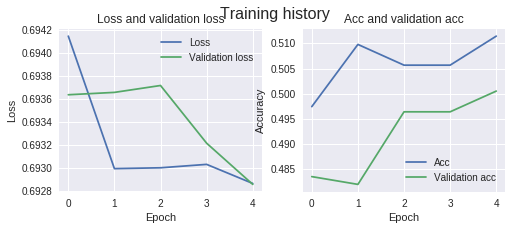

In [30]:
# # Plotting
# f, axs = plt.subplots(3,1, sharex=True, figsize=(12,8))
# # Close price 
# ass_market.close.plot(ax=axs[0])
# axs[0].set_ylabel("Price")

plt.figure(1, figsize=(8,3))
plt.subplot(121)
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title("Loss and validation loss")
plt.legend(["Loss", "Validation loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(122)
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title("Acc and validation acc")
plt.legend(["Acc", "Validation acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.suptitle('Training history', fontsize=16)
plt.show()

In [31]:
def predict_on_test():
    # Predict on last test data
    pred_size=100
    pred_idx = market_test_idx.tail(pred_size + ModelFactory.look_back)
    market_df = market.loc[pred_idx.index]
    news_df = news.merge(pred_idx, on=['time'])
    # Get preprocessed X, y
    X_test, y_test = prepro.get_Xy(market_df, news_df)
    # Add there look back rows for LSTM
    X_test, y_test = join_generator.with_look_back(X_test, y_test, look_back = ModelFactory.look_back, look_back_step=ModelFactory.look_back_step)
    
    # Predict
    y_pred = model.predict(X_test)*2-1

    # Plot
    ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
    ax1.plot(market_df['returnsOpenNextMktres10'].values, linestyle='none', marker='.', color='darkblue')
    ax1.plot(y_pred, linestyle='none', marker='.', color='darkorange')
    ax1.legend(["Ground truth","Predicted"])
    ax1.set_title("Both")
    ax1.set_xlabel("Epoch")
    ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1,rowspan=1)
    ax2.plot(market_df['returnsOpenNextMktres10'].values, linestyle='none', marker='.', color='darkblue')
    ax2.set_title("Ground truth")
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1,rowspan=1)
    ax3.plot(y_pred, linestyle='none', marker='.', color='darkorange')
    ax3.set_title("Predicted")
    plt.tight_layout()
    plt.show()

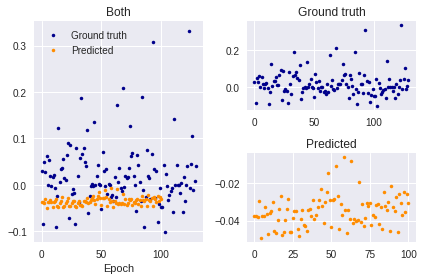

In [32]:
predict_on_test()

In [33]:
def make_predictions(market_obs_df, news_obs_df, predictions_template_df):
    """
    Predict confidence for one day and update predictions_template_df['confidenceValue']
    @param market_obs_df: market_obs_df returned from env
    @param predictions_template_df: predictions_template_df returned from env.
    @return: None. prediction_template_df updated instead. 
    """
    # Preprocess the data
    X = prepro.get_X(market_obs_df, news_obs_df)
    # Add look back window for LSTM, passing X only - we don't know y, we are predicting them
    X = join_generator.with_look_back(X, None, look_back=ModelFactory.look_back, look_back_step=ModelFactory.look_back_step)
    # Predict
    y_pred = model.predict(X)
    confidence_df=pd.DataFrame(y_pred*2-1, columns=['confidence'])

    # Merge predicted confidence to predictions template
    pred_df = pd.concat([predictions_template_df, confidence_df], axis=1).fillna(0)
    predictions_template_df.confidenceValue = pred_df.confidence

In [34]:
# Save data here for later debugging on it
days_saved_data = []

# Store execution info for plotting later
predicted_days=[]
predicted_times=[]
last_predictions_template_df = None

# Predict day by day
days = env.get_prediction_days()
last_year=None
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    # Store the data for later debugging on it
    days_saved_data.append((market_obs_df, news_obs_df, predictions_template_df))
    # For later plotting
    predicted_days.append(market_obs_df.iloc[0].time.strftime('%Y-%m-%d'))
    time_start = time()
    # For logging
    cur_year = market_obs_df.iloc[0].time.strftime('%Y')
    if cur_year != last_year:
        print(f'Predicting {cur_year}...')
        last_year = cur_year

    # Call prediction func
    make_predictions(market_obs_df, news_obs_df, predictions_template_df)
    #!!!
    env.predict(predictions_template_df)
    
    # For later plotting
    last_predictions_template_df = predictions_template_df
    predicted_times.append(time()-time_start)
    #print("Prediction completed for ", predicted_days[-1])

Predicting 2017...
Predicting 2018...
Predicting 2019...


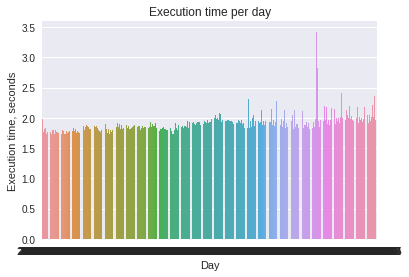

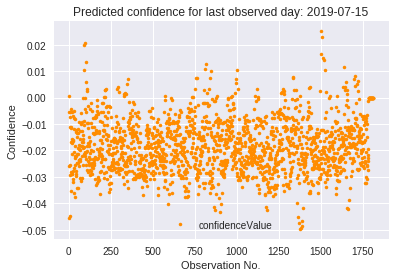

In [35]:
# Plot execution time 
sns.barplot(np.array(predicted_days), np.array(predicted_times))
plt.title("Execution time per day")
plt.xlabel("Day")
plt.ylabel("Execution time, seconds")
plt.show()

# Plot predicted confidence for last day
last_predictions_template_df.plot(linestyle='none', marker='.', color='darkorange')
plt.title("Predicted confidence for last observed day: %s" % predicted_days[-1])
plt.xlabel("Observation No.")
plt.ylabel("Confidence")
plt.show()

In [36]:
env.write_submission_file()
print([filename for filename in os.listdir('.') if '.csv' in filename])

Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.
['submission.csv']
